In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import xgboost as xgb
import os
import warnings
warnings.filterwarnings('ignore')

def load_data(gender='M'):
    """Load and prepare regular season and tournament data"""
    
    # Load data
    regular_season = pd.read_csv(f"/Users/dylan/bios635/final/march-machine-learning-mania-2025/{gender}RegularSeasonDetailedResults.csv")
    tourney_results = pd.read_csv(f"/Users/dylan/bios635/final/march-machine-learning-mania-2025/{gender}NCAATourneyDetailedResults.csv")
    
    # Print sample of data for verification
    print(f"{gender} Regular Season Data Shape: {regular_season.shape}")
    print(f"{gender} Tournament Data Shape: {tourney_results.shape}")
    
    return regular_season, tourney_results

def create_team_stats(regular_season_data, season):
    """Create team statistics for a specific season with improved normalization"""
    
    # Filter data for the specific season
    season_data = regular_season_data[regular_season_data['Season'] == season].copy()
    
    # Collect team stats
    team_stats = {}
    
    # Get all unique team IDs
    team_ids = set(season_data['WTeamID'].unique()) | set(season_data['LTeamID'].unique())
    
    # Create stats containers for season normalization
    all_win_pcts = []
    all_pts_scored = []
    all_pts_allowed = []
    all_fg_pcts = []
    all_fg3_pcts = []
    all_ft_pcts = []
    all_rebounds = []
    all_assists = []
    all_steals = []
    all_blocks = []
    all_turnovers = []
    #all_assist_turnover_ratios = []
    #all_oer = [] # new
    #all_der = [] # new
    
    # First pass: Calculate raw stats for each team
    for team_id in team_ids:
        # Games where team won
        team_wins = season_data[season_data['WTeamID'] == team_id].copy()
        # Games where team lost
        team_losses = season_data[season_data['LTeamID'] == team_id].copy()
        
        # Count games and calculate win percentage
        num_wins = len(team_wins)
        num_losses = len(team_losses)
        total_games = num_wins + num_losses
        win_percentage = num_wins / total_games if total_games > 0 else 0
        all_win_pcts.append(win_percentage)
        
        # Calculate offensive and defensive stats
        pts_scored = team_wins['WScore'].sum() + team_losses['LScore'].sum()
        pts_allowed = team_wins['LScore'].sum() + team_losses['WScore'].sum()
        
        # Calculate average points per game
        avg_pts_scored = pts_scored / total_games if total_games > 0 else 0
        avg_pts_allowed = pts_allowed / total_games if total_games > 0 else 0
        all_pts_scored.append(avg_pts_scored)
        all_pts_allowed.append(avg_pts_allowed)
        
        # Create advanced stats
        # Field goal percentage
        fg_made = team_wins['WFGM'].sum() + team_losses['LFGM'].sum()
        fg_attempts = team_wins['WFGA'].sum() + team_losses['LFGA'].sum()
        fg_percentage = fg_made / fg_attempts if fg_attempts > 0 else 0
        all_fg_pcts.append(fg_percentage)
        
        # 3-point percentage
        fg3_made = team_wins['WFGM3'].sum() + team_losses['LFGM3'].sum()
        fg3_attempts = team_wins['WFGA3'].sum() + team_losses['LFGA3'].sum()
        fg3_percentage = fg3_made / fg3_attempts if fg3_attempts > 0 else 0
        all_fg3_pcts.append(fg3_percentage)
        
        # Free throw percentage
        ft_made = team_wins['WFTM'].sum() + team_losses['LFTM'].sum()
        ft_attempts = team_wins['WFTA'].sum() + team_losses['LFTA'].sum()
        ft_percentage = ft_made / ft_attempts if ft_attempts > 0 else 0
        all_ft_pcts.append(ft_percentage)
        
        # Rebounding
        offensive_rebounds = team_wins['WOR'].sum() + team_losses['LOR'].sum()
        defensive_rebounds = team_wins['WDR'].sum() + team_losses['LDR'].sum()
        total_rebounds = offensive_rebounds + defensive_rebounds
        avg_rebounds = total_rebounds / total_games if total_games > 0 else 0
        all_rebounds.append(avg_rebounds)
        
        # Assists, turnovers, steals, blocks
        assists = team_wins['WAst'].sum() + team_losses['LAst'].sum()
        turnovers = team_wins['WTO'].sum() + team_losses['LTO'].sum()
        steals = team_wins['WStl'].sum() + team_losses['LStl'].sum()
        blocks = team_wins['WBlk'].sum() + team_losses['LBlk'].sum()
        
        # Calculate per game averages
        avg_assists = assists / total_games if total_games > 0 else 0
        avg_turnovers = turnovers / total_games if total_games > 0 else 0
        avg_steals = steals / total_games if total_games > 0 else 0
        avg_blocks = blocks / total_games if total_games > 0 else 0
        assist_to_turnover = assists / turnovers if turnovers > 0 else 0

        # OER, DER
        oer = pts_scored / fg_attempts + (0.9 * ft_attempts / 2) + turnovers
        der = pts_allowed / fg_attempts + (0.9 * ft_attempts / 2) + turnovers
        
        all_assists.append(avg_assists)
        all_steals.append(avg_steals)
        all_blocks.append(avg_blocks)
        all_turnovers.append(avg_turnovers)
        #all_assist_turnover_ratios.append(assist_to_turnover)
        #all_oer.append(oer)
        #all_der.append(der)
        
        # Store raw stats temporarily
        team_stats[team_id] = {
            'win_percentage': win_percentage,
            'avg_pts_scored': avg_pts_scored,
            'avg_pts_allowed': avg_pts_allowed,
            'fg_percentage': fg_percentage,
            'fg3_percentage': fg3_percentage,
            'ft_percentage': ft_percentage,
            'avg_rebounds': avg_rebounds,
            'avg_assists': avg_assists,
            'avg_turnovers': avg_turnovers,
            'avg_steals': avg_steals,
            'avg_blocks': avg_blocks,
            #'assist_to_turnover': assist_to_turnover,
            #'OER': oer,
            #'DER': der,
            'num_games': total_games
        }
    
    # Create different scalers for different types of features
    # For percentage features (already between 0-1)
    minmax_scaler = MinMaxScaler()
    # For features with potential outliers
    robust_scaler = RobustScaler()
    # For normally distributed features
    standard_scaler = StandardScaler()
    
    # Prepare arrays for scaling
    percentages_array = np.array([all_win_pcts, all_fg_pcts, all_fg3_pcts, all_ft_pcts]).T
    scoring_array = np.array([all_pts_scored, all_pts_allowed]).T
    other_stats_array = np.array([all_rebounds, all_assists, all_steals, all_blocks, all_turnovers]).T
    
    # Fit scalers if enough data
    if len(percentages_array) > 1:
        minmax_scaler.fit(percentages_array)
    if len(scoring_array) > 1:
        robust_scaler.fit(scoring_array)
    if len(other_stats_array) > 1:
        standard_scaler.fit(other_stats_array)
    
    # Second pass: Normalize stats for each team
    normalized_stats = {}
    for team_id in team_ids:
        raw_stats = team_stats[team_id]
        
        # Scale percentage features
        pct_features = np.array([[
            raw_stats['win_percentage'],
            raw_stats['fg_percentage'],
            raw_stats['fg3_percentage'],
            raw_stats['ft_percentage']
        ]])
        
        # Scale scoring features
        scoring_features = np.array([[
            raw_stats['avg_pts_scored'],
            raw_stats['avg_pts_allowed']
        ]])
        
        # Scale other features
        other_features = np.array([[
            raw_stats['avg_rebounds'],
            raw_stats['avg_assists'],
            raw_stats['avg_steals'],
            raw_stats['avg_blocks'],
            raw_stats['avg_turnovers']
            #raw_stats['assist_to_turnover'],
            #raw_stats['OER'],
            #raw_stats['DER']
        ]])
        
        # Apply transformation if we have enough data
        if len(percentages_array) > 1:
            scaled_pct = minmax_scaler.transform(pct_features)[0]
        else:
            scaled_pct = pct_features[0]
            
        if len(scoring_array) > 1:
            scaled_scoring = robust_scaler.transform(scoring_features)[0]
        else:
            scaled_scoring = scoring_features[0]
            
        if len(other_stats_array) > 1:
            scaled_other = standard_scaler.transform(other_features)[0]
        else:
            scaled_other = other_features[0]
        
        # Create net rating from scaled values
        #net_rating = raw_stats['avg_pts_scored'] - raw_stats['avg_pts_allowed']
        
        # Store normalized stats
        normalized_stats[team_id] = {
            'win_percentage': scaled_pct[0],
            'avg_pts_scored': scaled_scoring[0],
            'avg_pts_allowed': scaled_scoring[1],
            #'net_rating': net_rating,  # Keep net rating as raw difference
            'fg_percentage': scaled_pct[1],
            'fg3_percentage': scaled_pct[2],
            'ft_percentage': scaled_pct[3],
            'avg_rebounds': scaled_other[0],
            'avg_assists': scaled_other[1],
            'avg_steals': scaled_other[2],
            'avg_blocks': scaled_other[3],
            'avg_turnovers': scaled_other[4],
            #'assist_to_turnover': scaled_other[5],
            #'OER': scaled_other[6], # new
            #'DER': scaled_other[7], # new
            'num_games': raw_stats['num_games']
        }
    
    return normalized_stats

def create_features(team1_id, team2_id, team_stats, season):
    """Create features for a matchup between two teams"""
    
    # Check if both teams have stats
    if team1_id not in team_stats or team2_id not in team_stats:
        # If one team doesn't have stats, return neutral features
        return [0.0] * 11
    
    team1 = team_stats[team1_id]
    team2 = team_stats[team2_id]
    
    # Create feature differences (team1 - team2)
    features = [
        team1['win_percentage'] - team2['win_percentage'],
        team1['avg_pts_scored'] - team2['avg_pts_scored'],
        team1['avg_pts_allowed'] - team2['avg_pts_allowed'],
        #team1['net_rating'] - team2['net_rating'],
        team1['fg_percentage'] - team2['fg_percentage'],
        team1['fg3_percentage'] - team2['fg3_percentage'],
        team1['ft_percentage'] - team2['ft_percentage'],
        team1['avg_rebounds'] - team2['avg_rebounds'],
        team1['avg_assists'] - team2['avg_assists'],
        team1['avg_steals'] - team2['avg_steals'],
        team1['avg_blocks'] - team2['avg_blocks'],
        team1['avg_turnovers'] - team2['avg_turnovers']
        #team1['assist_to_turnover'] - team2['assist_to_turnover'],
        #team1['OER'] - team2['OER'], # new
        #team1['DER'] - team2['DER'] # new
    ]
    
    return features

def prepare_training_data(regular_season_data, tourney_data):
    """Prepare the training data from regular season and tournament results"""
    X = []
    y = []
    groups = []
    
    # Use data from 2003 to 2024 for training
    seasons = regular_season_data['Season'].unique()
    #seasons = [s for s in seasons if s < 2025]
    
    for season in seasons:
        print(f"Processing season {season}...")
        
        # Create team stats for the season
        team_stats = create_team_stats(regular_season_data, season)
        
        # Process regular season games
        season_games = regular_season_data[regular_season_data['Season'] == season]
        
        for _, game in season_games.iterrows():
            team1_id = min(game['WTeamID'], game['LTeamID'])
            team2_id = max(game['WTeamID'], game['LTeamID'])
            
            # Create features for this matchup
            features = create_features(team1_id, team2_id, team_stats, season)
            
            # Add to training data
            X.append(features)
            
            # Label is 1 if team1 won, 0 if team2 won
            result = 1 if game['WTeamID'] == team1_id else 0
            y.append(result)
            
            # Keep track of which season this game belongs to for group CV
            groups.append(season)
        
        # Process tournament games
        tourney_season_games = tourney_data[tourney_data['Season'] == season]
        
        for _, game in tourney_season_games.iterrows():
            team1_id = min(game['WTeamID'], game['LTeamID'])
            team2_id = max(game['WTeamID'], game['LTeamID'])
            
            # Create features for this matchup
            features = create_features(team1_id, team2_id, team_stats, season)
            
            # Add to training data
            X.append(features)
            
            # Label is 1 if team1 won, 0 if team2 won
            result = 1 if game['WTeamID'] == team1_id else 0
            y.append(result)
            
            # Keep track of which season this game belongs to for group CV
            groups.append(season)
    
    return np.array(X), np.array(y), np.array(groups)

# Shared cross-validation strategy
def get_group_kfold():
    return GroupKFold(n_splits=5)

def train_logistic_regression(X, y, groups):
    param_dist = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced']
    }
   
    model = RandomizedSearchCV(
        LogisticRegression(max_iter=10000, random_state=42),
        param_distributions=param_dist,
        n_iter=10,
        cv=get_group_kfold().split(X, y, groups),
        scoring='neg_brier_score',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    model.fit(X, y)
    print("Logistic Regression - Best params:", model.best_params_)
    print("Logistic Regression - CV Brier Score:", -model.best_score_)
    return model

def train_random_forest(X, y, groups):
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }
   
    model = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=10,
        cv=get_group_kfold().split(X, y, groups),
        scoring='neg_brier_score',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    model.fit(X, y)
    print("Random Forest - Best params:", model.best_params_)
    print("Random Forest - CV Brier Score:", -model.best_score_)
    return model

def train_xgboost(X, y, groups):
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.03, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0, 0.1]
    }
   
    model = RandomizedSearchCV(
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        param_distributions=param_dist,
        n_iter=10,
        cv=get_group_kfold().split(X, y, groups),
        scoring='neg_brier_score',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    model.fit(X, y)
    print("XGBoost - Best params:", model.best_params_)
    print("XGBoost - CV Brier Score:", -model.best_score_)
    return model

def train_neural_network(X, y, groups):
    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    }
    
    model = RandomizedSearchCV(
        MLPClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=10,
        cv=get_group_kfold().split(X, y, groups),
        scoring='neg_brier_score',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    model.fit(X, y)
    print("Neural Network - Best params:", model.best_params_)
    print("Neural Network - CV Brier Score:", -model.best_score_)
    return model

def generate_predictions_for_2025(models, regular_season_data, gender):
    """Generate predictions for all possible matchups in 2025 using ensemble of models"""
    
    # Create team stats for 2024 (as a proxy for 2025)
    team_stats = create_team_stats(regular_season_data, 2024)
    
    # Get all unique team IDs
    team_ids = set(regular_season_data['WTeamID'].unique()) | set(regular_season_data['LTeamID'].unique())
    team_ids = list(team_ids)
    
    # Generate all possible matchups
    predictions = []
    
    for i in range(len(team_ids)):
        for j in range(i+1, len(team_ids)):
            team1_id = team_ids[i]
            team2_id = team_ids[j]
            
            # Create features for this matchup
            features = create_features(team1_id, team2_id, team_stats, 2025)
            features = np.array([features])
            
            # Get predictions from each model
            probabilities = []
            for model_name, model in models.items():
                prob = model.predict_proba(features)[0][1]
                probabilities.append(prob)
            
            # Average the probabilities from all models
            avg_prob = sum(probabilities) / len(probabilities)
            
            # Format the prediction for submission
            prediction_id = f"2025_{team1_id}_{team2_id}"
            predictions.append({'ID': prediction_id, 'Pred': avg_prob})
    
    # Convert to DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    return predictions_df

def calculate_brier_score(predictions_df, results_data, gender):
    """Calculate Brier score for the 2025 predictions"""
    
    # Process the results data to get the actual outcomes
    actual_outcomes = {}
    
    for _, game in results_data.iterrows():
        team1_id = min(game['WTeamID'], game['LTeamID'])
        team2_id = max(game['WTeamID'], game['LTeamID'])
        
        # Result is 1 if team1 won, 0 if team2 won
        result = 1 if game['WTeamID'] == team1_id else 0
        
        # Create ID in the same format as predictions
        game_id = f"2025_{team1_id}_{team2_id}"
        actual_outcomes[game_id] = result
    
    # Match predictions with actual outcomes
    y_true = []
    y_pred = []
    
    for _, row in predictions_df.iterrows():
        game_id = row['ID']
        if game_id in actual_outcomes:
            y_true.append(actual_outcomes[game_id])
            y_pred.append(row['Pred'])
    
    # Calculate Brier score
    brier = brier_score_loss(y_true, y_pred)
    print(f"{gender} Tournament Brier Score: {brier}")
    
    return brier, len(y_true)

def parse_results_data(results_str, gender):
    """Parse the results data string into a dataframe"""
    lines = results_str.strip().split('\n')
    headers = lines[0].split(',')
    data = []
    
    for line in lines[1:]:
        if line.strip():  # Skip empty lines
            values = line.split(',')
            data.append(dict(zip(headers, values)))
    
    results_df = pd.DataFrame(data)
    
    # Convert numeric columns
    numeric_columns = ['Season', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'NumOT']
    for col in numeric_columns:
        if col in results_df.columns:
            results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    
    # Filter for 2025 season
    results_df = results_df[results_df['Season'] == 2025]
    
    return results_df

def evaluate_individual_models(models, X, results_data, gender):
    """Evaluate each model individually on the test data"""
    for model_name, model in models.items():
        # Generate predictions for just this model
        predictions = []
        
        for _, game in results_data.iterrows():
            team1_id = min(game['WTeamID'], game['LTeamID'])
            team2_id = max(game['WTeamID'], game['LTeamID'])
            
            # Create ID for this game
            game_id = f"2025_{team1_id}_{team2_id}"
            
            # Create team stats for 2024 (as a proxy for 2025)
            team_stats = create_team_stats(X, 2024)
            
            # Create features for this matchup
            features = create_features(team1_id, team2_id, team_stats, 2025)
            features = np.array([features])
            
            # Get prediction
            prob = model.predict_proba(features)[0][1]
            
            # Format the prediction
            predictions.append({'ID': game_id, 'Pred': prob})
        
        # Convert to DataFrame
        predictions_df = pd.DataFrame(predictions)
        
        # Calculate Brier score
        brier, _ = calculate_brier_score(predictions_df, results_data, gender)
        
        print(f"{gender} Tournament - {model_name} Brier Score: {brier}")



Exception ignored in: <function ResourceTracker.__del__ at 0x1062d8220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107ecc220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

### Hierarchical Clustering

In [10]:
def read_csv_files_in_folder(folder_path):
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df_name = "df_" + os.path.splitext(filename)[0]

            try:
                df = pd.read_csv(file_path)
                globals()[df_name] = df
                print(f"Read and created DataFrame: {df_name} from {filename}")
            except Exception as e:
                print(f"Error reading {filename}: {e}")

folder_path = '/Users/dylan/bios635/final/march-machine-learning-mania-2025'
read_csv_files_in_folder(folder_path)

Read and created DataFrame: df_MNCAATourneyDetailedResults from MNCAATourneyDetailedResults.csv
Read and created DataFrame: df_SampleSubmissionStage2 from SampleSubmissionStage2.csv
Read and created DataFrame: df_WSecondaryTourneyTeams from WSecondaryTourneyTeams.csv
Read and created DataFrame: df_WNCAATourneySlots from WNCAATourneySlots.csv
Read and created DataFrame: df_MNCAATourneyCompactResults from MNCAATourneyCompactResults.csv
Read and created DataFrame: df_MSeasons from MSeasons.csv
Read and created DataFrame: df_SampleSubmissionStage1 from SampleSubmissionStage1.csv
Read and created DataFrame: df_WTeams from WTeams.csv
Read and created DataFrame: df_MRegularSeasonDetailedResults from MRegularSeasonDetailedResults.csv
Read and created DataFrame: df_WNCAATourneyDetailedResults from WNCAATourneyDetailedResults.csv
Read and created DataFrame: df_MNCAATourneySlots from MNCAATourneySlots.csv
Read and created DataFrame: df_MGameCities from MGameCities.csv
Read and created DataFrame: 

### Men's data

In [ ]:
# === Load tournament detailed results ===
tourney = pd.read_csv("/Users/dylan/bios635/final/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv")
tourney = tourney[tourney['Season'] >= 2003].copy()

# === Load regular season detailed results ===
season = pd.read_csv("/Users/dylan/bios635/final/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv")
season = season[season['Season'] >= 2003].copy()

team_names = pd.read_csv('/Users/dylan/bios635/final/mapped_2025_teamIDs.csv')

# === Combine
all_data = pd.concat([tourney, season], axis = 0 ,ignore_index=True)

# === Define stat columns ===
stat_cols = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
             'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Score']

# Build team-level stats
w_stats = tourney[['Season', 'WTeamID'] + ['W' + col for col in stat_cols]]
l_stats = tourney[['Season', 'LTeamID'] + ['L' + col for col in stat_cols]]

w_stats.columns = ['Season', 'TeamID'] + stat_cols
l_stats.columns = ['Season', 'TeamID'] + stat_cols

all_stats = pd.concat([w_stats, l_stats])
team_stats = all_stats.groupby(['Season', 'TeamID']).mean().reset_index()

# Add win/loss records
wins = tourney.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins')
losses = tourney.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses')

record = pd.merge(wins, losses, how='outer', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
record['TeamID'] = record['WTeamID'].combine_first(record['LTeamID'])
record = record[['Season', 'TeamID', 'Wins', 'Losses']].fillna(0)
record['WinPct'] = record['Wins'] / (record['Wins'] + record['Losses'])

# Merge into team features
team_features = pd.merge(team_stats, record, on=['Season', 'TeamID'], how='left')

# === Create training matchups and labels ===
games = tourney[['Season', 'WTeamID', 'LTeamID']].copy()
games['Team1'] = games[['WTeamID', 'LTeamID']].min(axis=1)
games['Team2'] = games[['WTeamID', 'LTeamID']].max(axis=1)
games['Team1Win'] = (games['WTeamID'] < games['LTeamID']).astype(int)

# === Merge features ===
t1 = team_features.copy()
t2 = team_features.copy()
t1.columns = ['Season'] + ['Team1_' + col for col in t1.columns[1:]]
t2.columns = ['Season'] + ['Team2_' + col for col in t2.columns[1:]]

X = games.merge(t1, left_on=['Season', 'Team1'], right_on=['Season', 'Team1_TeamID'])
X = X.merge(t2, left_on=['Season', 'Team2'], right_on=['Season', 'Team2_TeamID'])

# === Compute feature differences ===
feature_cols = [col for col in t1.columns if col not in ['Season', 'Team1_TeamID']]
diff_features = []

for col in feature_cols:
    col2 = col.replace('Team1_', 'Team2_')
    if col in X and col2 in X:
        new_col = 'diff_' + col.replace('Team1_', '')
        X[new_col] = X[col] - X[col2]
        diff_features.append(new_col)

team_features.tail()

,Season,TeamID,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Score,Wins,Losses,WinPct
1398,2024,1443,28.0,69.0,8.0,24.0,5.0,6.0,12.0,30.0,17.0,18.0,5.0,4.0,15.0,69.0,0.0,1.0,0.0
1399,2024,1447,26.0,56.5,7.5,17.5,7.0,12.0,5.0,18.5,12.0,7.5,5.0,3.5,14.5,66.5,1.0,1.0,0.5
1400,2024,1450,21.5,53.0,6.0,18.5,12.0,15.5,10.0,24.5,10.5,11.5,4.0,6.0,14.5,61.0,1.0,1.0,0.5
1401,2024,1458,19.0,51.0,8.0,21.0,15.0,23.0,7.0,26.0,13.0,19.0,6.0,3.0,19.0,61.0,0.0,1.0,0.0
1402,2024,1463,22.0,53.0,8.0,19.5,15.5,22.5,5.0,16.0,11.5,10.5,9.0,1.0,16.5,67.5,1.0,1.0,0.5


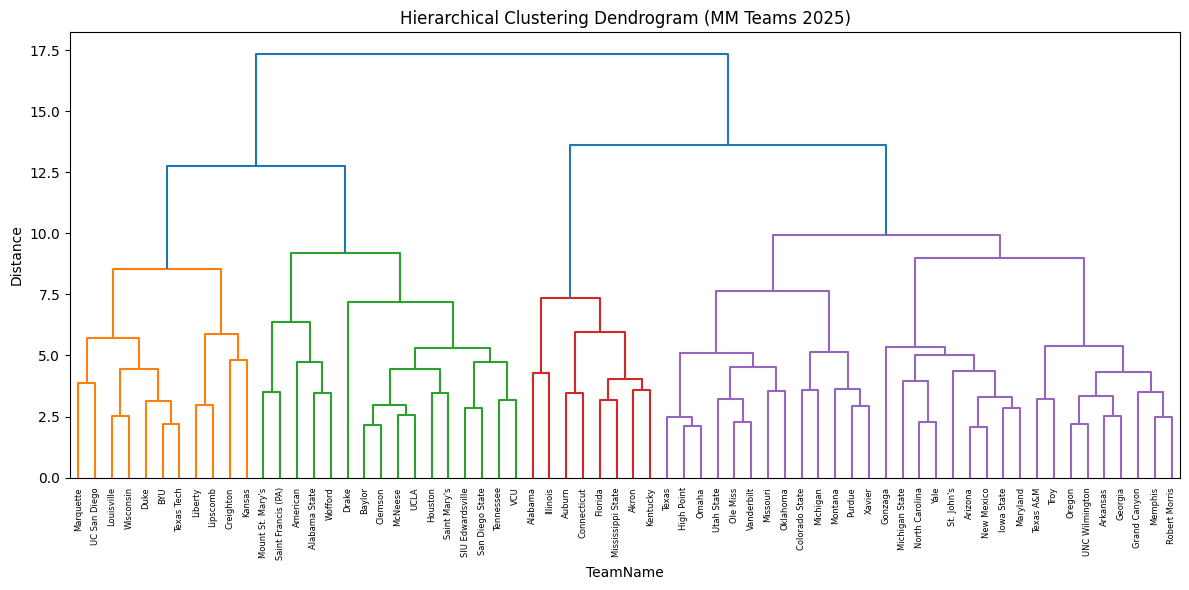

Cluster
1    11
2    16
3     8
4    31
Name: count, dtype: int64


In [61]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

season_2025_men = season[season['Season'] == 2025]

# Step 3: Select & rename winning team stats
w_cols = {
    'WTeamID': 'TeamID',
    'WScore': 'Points', 'WFGA': 'FGA', 'WFTA': 'FTA', 'WTO': 'TO',
    'LScore': 'OppPoints', 'WFGM': 'FGM', 'WFGM3': 'FGM3', 'WFGA3': 'FGA3',
    'WFTM': 'FTM', 'WOR': 'OR', 'WDR': 'DR', 'WAst': 'Ast', 'WStl': 'Stl',
    'WBlk': 'Blk', 'WPF': 'PF'
}
w_stats = season_2025_men[list(w_cols.keys())].rename(columns=w_cols)

# Step 4: Select & rename losing team stats
l_cols = {
    'LTeamID': 'TeamID',
    'LScore': 'Points', 'LFGA': 'FGA', 'LFTA': 'FTA', 'LTO': 'TO',
    'WScore': 'OppPoints', 'LFGM': 'FGM', 'LFGM3': 'FGM3', 'LFGA3': 'FGA3',
    'LFTM': 'FTM', 'LOR': 'OR', 'LDR': 'DR', 'LAst': 'Ast', 'LStl': 'Stl',
    'LBlk': 'Blk', 'LPF': 'PF'
}
l_stats = season_2025_men[list(l_cols.keys())].rename(columns=l_cols)

# Step 5: Combine win/loss stats and average by team
team_game_stats = pd.concat([w_stats, l_stats])
avg_stats = team_game_stats.groupby('TeamID').mean().reset_index()

#team_names.drop('MatchedName', axis=1, inplace=True)
avg_stats.head()

tournament_teams = pd.merge(avg_stats, team_names, on='TeamID', how='left')
tournament_teams = tournament_teams.dropna(subset=['TeamName'])
tournament_teams.drop('TeamID', axis = 1, inplace=True)

tournament_teams.head()

features = tournament_teams.drop(columns=['TeamName'])  # Drop TeamID column
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)  # Scaling

# Step 2: Hierarchical Clustering (Ward’s linkage minimizes variance)
linked = linkage(scaled_features, method='ward')  # Perform hierarchical clustering

# Step 3: Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=tournament_teams['TeamName'].values, leaf_rotation=90, color_threshold=10)
plt.title("Hierarchical Clustering Dendrogram (MM Teams 2025)")
plt.xlabel("TeamName")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Optional: Cutting the dendrogram into clusters
tournament_teams['Cluster'] = fcluster(linked, t=4, criterion='maxclust')  # e.g., cut into 5 clusters

# Inspecting cluster counts
cluster_counts = tournament_teams['Cluster'].value_counts().sort_index()
print(cluster_counts)

### Women's Data

In [83]:
# === Load tournament detailed results ===
tourney = pd.read_csv("/Users/dylan/bios635/final/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv")
tourney = tourney[tourney['Season'] >= 2003].copy()

# === Load regular season detailed results ===
season = pd.read_csv("/Users/dylan/bios635/final/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv")
season = season[season['Season'] >= 2003].copy()

team_names = pd.read_csv('/Users/dylan/bios635/final/womens_mapped_teams.csv')

# === Combine
all_data = pd.concat([tourney, season], axis = 0 ,ignore_index=True)

# === Define stat columns ===
stat_cols = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
             'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Score']

# Build team-level stats
w_stats = tourney[['Season', 'WTeamID'] + ['W' + col for col in stat_cols]]
l_stats = tourney[['Season', 'LTeamID'] + ['L' + col for col in stat_cols]]

w_stats.columns = ['Season', 'TeamID'] + stat_cols
l_stats.columns = ['Season', 'TeamID'] + stat_cols

all_stats = pd.concat([w_stats, l_stats])
team_stats = all_stats.groupby(['Season', 'TeamID']).mean().reset_index()

# Add win/loss records
wins = tourney.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins')
losses = tourney.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses')

record = pd.merge(wins, losses, how='outer', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
record['TeamID'] = record['WTeamID'].combine_first(record['LTeamID'])
record = record[['Season', 'TeamID', 'Wins', 'Losses']].fillna(0)
record['WinPct'] = record['Wins'] / (record['Wins'] + record['Losses'])

# Merge into team features
team_features = pd.merge(team_stats, record, on=['Season', 'TeamID'], how='left')

# === Create training matchups and labels ===
games = tourney[['Season', 'WTeamID', 'LTeamID']].copy()
games['Team1'] = games[['WTeamID', 'LTeamID']].min(axis=1)
games['Team2'] = games[['WTeamID', 'LTeamID']].max(axis=1)
games['Team1Win'] = (games['WTeamID'] < games['LTeamID']).astype(int)

# === Merge features ===
t1 = team_features.copy()
t2 = team_features.copy()
t1.columns = ['Season'] + ['Team1_' + col for col in t1.columns[1:]]
t2.columns = ['Season'] + ['Team2_' + col for col in t2.columns[1:]]

X = games.merge(t1, left_on=['Season', 'Team1'], right_on=['Season', 'Team1_TeamID'])
X = X.merge(t2, left_on=['Season', 'Team2'], right_on=['Season', 'Team2_TeamID'])

# === Compute feature differences ===
feature_cols = [col for col in t1.columns if col not in ['Season', 'Team1_TeamID']]
diff_features = []

for col in feature_cols:
    col2 = col.replace('Team1_', 'Team2_')
    if col in X and col2 in X:
        new_col = 'diff_' + col.replace('Team1_', '')
        X[new_col] = X[col] - X[col2]
        diff_features.append(new_col)

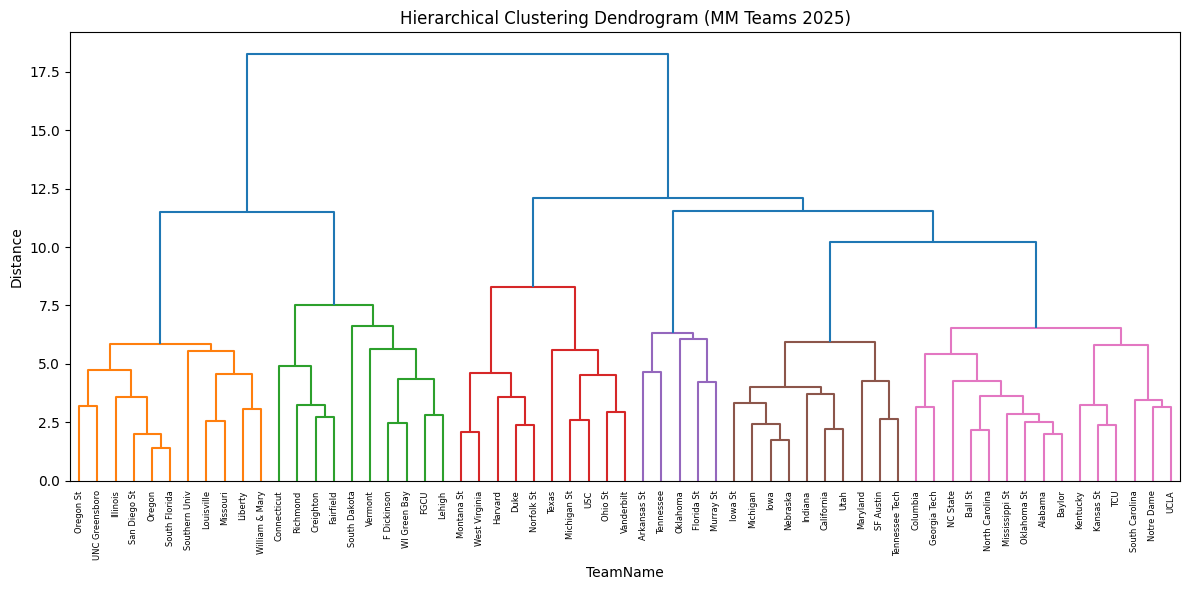

Cluster
1    21
2    10
3     5
4    25
Name: count, dtype: int64


In [85]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

season_2025_women = season[season['Season'] == 2025]

# Step 3: Select & rename winning team stats
w_cols = {
    'WTeamID': 'TeamID',
    'WScore': 'Points', 'WFGA': 'FGA', 'WFTA': 'FTA', 'WTO': 'TO',
    'LScore': 'OppPoints', 'WFGM': 'FGM', 'WFGM3': 'FGM3', 'WFGA3': 'FGA3',
    'WFTM': 'FTM', 'WOR': 'OR', 'WDR': 'DR', 'WAst': 'Ast', 'WStl': 'Stl',
    'WBlk': 'Blk', 'WPF': 'PF'
}
w_stats = season_2025_women[list(w_cols.keys())].rename(columns=w_cols)

# Step 4: Select & rename losing team stats
l_cols = {
    'LTeamID': 'TeamID',
    'LScore': 'Points', 'LFGA': 'FGA', 'LFTA': 'FTA', 'LTO': 'TO',
    'WScore': 'OppPoints', 'LFGM': 'FGM', 'LFGM3': 'FGM3', 'LFGA3': 'FGA3',
    'LFTM': 'FTM', 'LOR': 'OR', 'LDR': 'DR', 'LAst': 'Ast', 'LStl': 'Stl',
    'LBlk': 'Blk', 'LPF': 'PF'
}
l_stats = season_2025_women[list(l_cols.keys())].rename(columns=l_cols)

# Step 5: Combine win/loss stats and average by team
team_game_stats = pd.concat([w_stats, l_stats])
avg_stats = team_game_stats.groupby('TeamID').mean().reset_index()

#team_names.drop('MatchedName', axis=1, inplace=True)
avg_stats.head()

tournament_teams = pd.merge(avg_stats, team_names, on='TeamID', how='left')
tournament_teams = tournament_teams.dropna(subset=['TeamName'])
tournament_teams.drop('TeamID', axis = 1, inplace=True)

tournament_teams.head()

features = tournament_teams.drop(columns=['TeamName'])  # Drop TeamID column
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)  # Scaling

# Step 2: Hierarchical Clustering (Ward’s linkage minimizes variance)
linked = linkage(scaled_features, method='ward')  # Perform hierarchical clustering

# Step 3: Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=tournament_teams['TeamName'].values, leaf_rotation=90, color_threshold=10)
plt.title("Hierarchical Clustering Dendrogram (MM Teams 2025)")
plt.xlabel("TeamName")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Optional: Cutting the dendrogram into clusters
tournament_teams['Cluster'] = fcluster(linked, t=4, criterion='maxclust')  # e.g., cut into 5 clusters

# Inspecting cluster counts
cluster_counts = tournament_teams['Cluster'].value_counts().sort_index()
print(cluster_counts)

### Feature Engineering

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

m_regular_season, m_tourney = load_data('M')
X_m, y_m, groups_m = prepare_training_data(m_regular_season, m_tourney)

M Regular Season Data Shape: (118882, 34)
M Tournament Data Shape: (1382, 34)
Processing season 2003...
Processing season 2004...
Processing season 2005...
Processing season 2006...
Processing season 2007...
Processing season 2008...
Processing season 2009...
Processing season 2010...
Processing season 2011...
Processing season 2012...
Processing season 2013...
Processing season 2014...
Processing season 2015...
Processing season 2016...
Processing season 2017...
Processing season 2018...
Processing season 2019...
Processing season 2020...
Processing season 2021...
Processing season 2022...
Processing season 2023...
Processing season 2024...


In [98]:
feature_names = ['win_percentage', 'avg_pts_scored', 'avg_pts_allowed', 'net_rating',
                 'fg_percentage', 'fg3_percentage', 'ft_percentage', 'avg_rebounds',
                 'avg_assists', 'avg_steals', 'avg_blocks', 'assist_to_turnover']

X_df = pd.DataFrame(X_m, columns=feature_names)

# Step 2: Add a constant column (intercept term) for the regression
X_with_const = add_constant(X_df)

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display the VIF data
print(vif_data) # should remove net_rating

               Feature         VIF
0                const    1.006792
1       win_percentage    8.407437
2       avg_pts_scored   79.319772
3      avg_pts_allowed   69.899273
4           net_rating  135.686713
5        fg_percentage    4.475731
6       fg3_percentage    2.033954
7        ft_percentage    1.495549
8         avg_rebounds    3.924641
9          avg_assists    4.675241
10          avg_steals    1.914978
11          avg_blocks    1.269858
12  assist_to_turnover    5.265014


### Correlation Matrix

M Regular Season Data Shape: (118882, 34)
M Tournament Data Shape: (1382, 34)
Processing season 2003...
Processing season 2004...
Processing season 2005...
Processing season 2006...
Processing season 2007...
Processing season 2008...
Processing season 2009...
Processing season 2010...
Processing season 2011...
Processing season 2012...
Processing season 2013...
Processing season 2014...
Processing season 2015...
Processing season 2016...
Processing season 2017...
Processing season 2018...
Processing season 2019...
Processing season 2020...
Processing season 2021...
Processing season 2022...
Processing season 2023...
Processing season 2024...


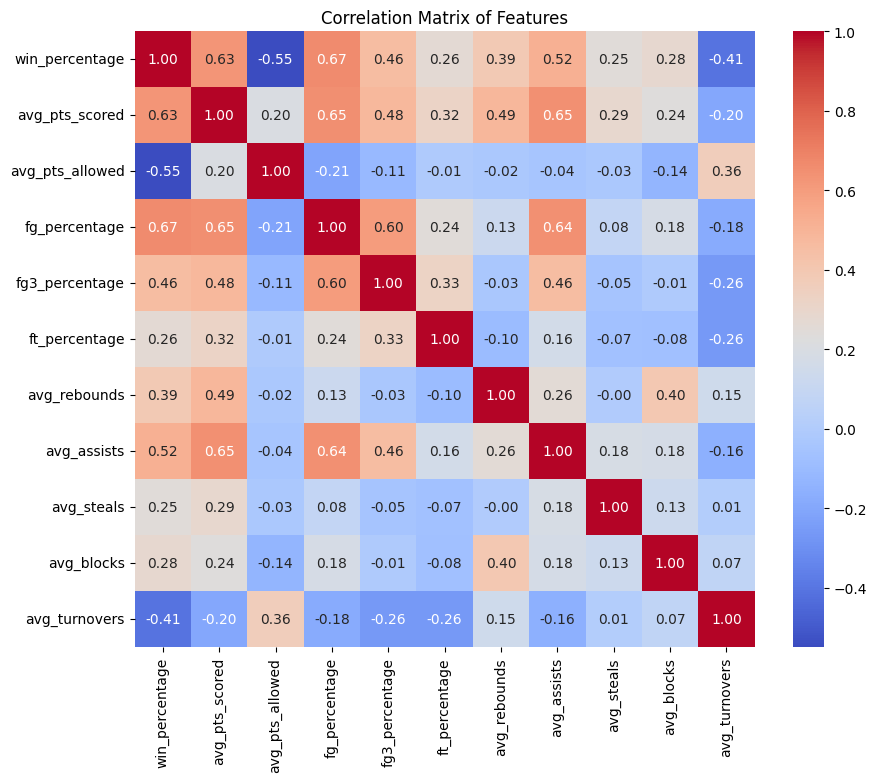

Exception ignored in: <function ResourceTracker.__del__ at 0x104dfc220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102654220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [10]:
# Men's tournament
m_regular_season, m_tourney = load_data('M')
X_m, y_m, groups_m = prepare_training_data(m_regular_season, m_tourney)

# Assuming X_m is a numpy array, convert it to a pandas DataFrame with feature names
# You can replace these names with your actual feature names
feature_names = [
    'win_percentage', 'avg_pts_scored', 'avg_pts_allowed', 'fg_percentage', 'fg3_percentage', 
    'ft_percentage', 'avg_rebounds', 'avg_assists', 'avg_steals', 'avg_blocks', 
    'avg_turnovers'  # Add all the features you have
]

X_m_df = pd.DataFrame(X_m, columns=feature_names)

correlation_matrix = X_m_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

### Evaluation

In [ ]:
def main():
    # Men's tournament
    m_regular_season, m_tourney = load_data('M')
    
    # Prepare training data
    print("Preparing men's training data...")
    X_m, y_m, groups_m = prepare_training_data(m_regular_season, m_tourney)
    
    # Train men's models
    print("Training men's logistic regression model...")
    m_logistic = train_logistic_regression(X_m, y_m, groups_m)
    
    print("Training men's random forest model...")
    m_rf = train_random_forest(X_m, y_m, groups_m)
    
    print("Training men's XGBoost model...")
    m_xgb = train_xgboost(X_m, y_m, groups_m)

    print("Training men's Neural Network model...")
    m_nn = train_neural_network(X_m, y_m, groups_m)
    
    # Combine men's models
    m_models = {
        'logistic': m_logistic,
        'random_forest': m_rf,
        'xgboost': m_xgb,
        'neural_network': m_nn
    }
    
    # Generate predictions for 2025 men's tournament
    print("Generating predictions for men's tournament...")
    m_predictions = generate_predictions_for_2025(m_models, m_regular_season, 'M')
    
    # Parse men's results data
    mens_results_str = """Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT
2025,,1222,63,1196,65,N,0
2025,,1120,73,1196,79,N,0
2025,,1181,67,1222,70,N,0
2025,,1397,61,1222,70,N,0
2025,,1277,64,1120,70,N,0
2025,,1403,79,1196,84,N,0
2025,,1104,65,1181,85,N,0
2025,,1276,65,1120,78,N,0
2025,,1345,60,1222,62,N,0
2025,,1246,65,1397,78,N,0
2025,,1279,70,1277,73,N,0
2025,,1112,93,1181,100,N,0
2025,,1116,83,1403,85,N,0
2025,,1140,88,1104,113,N,0
2025,,1268,71,1196,87,N,0
2025,,1332,83,1112,87,N,0
2025,,1307,63,1277,71,N,0
2025,,1161,71,1268,72,N,0
2025,,1235,78,1279,91,N,0
2025,,1388,66,1104,80,N,0
2025,,1228,75,1246,84,N,0
2025,,1124,66,1181,89,N,0
2025,,1163,75,1196,77,N,0
2025,,1385,66,1116,75,N,0
2025,,1166,70,1120,82,N,0
2025,,1458,89,1140,91,N,0
2025,,1211,76,1222,81,N,0
2025,,1417,58,1397,67,N,0
2025,,1270,62,1345,76,N,0
2025,,1401,79,1276,91,N,0
2025,,1179,64,1403,77,N,0
2025,,1328,59,1163,67,N,0
2025,,1462,73,1228,86,N,0
2025,,1136,62,1277,87,N,0
2025,,1251,52,1332,81,N,0
2025,,1313,69,1196,95,N,0
2025,,1407,57,1246,76,N,0
2025,,1266,66,1307,75,N,0
2025,,1103,65,1112,93,N,0
2025,,1291,49,1181,93,N,0
2025,,1435,56,1388,59,N,0
2025,,1314,64,1279,71,N,0
2025,,1213,49,1268,81,N,0
2025,,1280,72,1124,75,N,0
2025,,1352,81,1104,90,N,0
2025,,1252,55,1235,82,N,0
2025,,1272,70,1161,78,N,0
2025,,1429,47,1417,72,N,0
2025,,1303,53,1385,83,N,0
2025,,1471,65,1276,68,N,0
2025,,1423,72,1403,82,N,0
2025,,1281,57,1179,67,N,0
2025,,1463,71,1401,80,N,0
2025,,1242,72,1116,79,N,0
2025,,1459,62,1397,77,N,0
2025,,1433,71,1140,80,N,0
2025,,1208,68,1211,89,N,0
2025,,1106,63,1120,83,N,0
2025,,1155,67,1270,69,N,0
2025,,1285,66,1458,85,N,0
2025,,1188,40,1222,78,N,0
2025,,1219,63,1345,75,N,0
2025,,1257,75,1166,89,N,0
2025,,1400,80,1462,86,N,0
2025,,1110,72,1291,83,N,0
2025,,1384,68,1106,70,N,0
2025,,1361,68,1314,95,N,0"""
    
    m_results_df = parse_results_data(mens_results_str, 'M')
    
    # Calculate Brier score for men's predictions
    m_brier, m_count = calculate_brier_score(m_predictions, m_results_df, 'M')
    
    # Evaluate individual models
    print("Evaluating individual men's models...")
    evaluate_individual_models(m_models, m_regular_season, m_results_df, 'M')
    
    # Women's tournament
    w_regular_season, w_tourney = load_data('W')
    
    # Prepare training data
    print("Preparing women's training data...")
    X_w, y_w, groups_w = prepare_training_data(w_regular_season, w_tourney)
    
    # Train women's models
    print("Training women's logistic regression model...")
    w_logistic = train_logistic_regression(X_w, y_w, groups_w)
    
    print("Training women's random forest model...")
    w_rf = train_random_forest(X_w, y_w, groups_w)
    
    print("Training women's XGBoost model...")
    w_xgb = train_xgboost(X_w, y_w, groups_w)

    print("Training women's Neural Network model...")
    w_nn = train_neural_network(X_w, y_w, groups_w)
    
    # Combine women's models
    w_models = {
        'logistic': w_logistic,
        'random_forest': w_rf,
        'xgboost': w_xgb,
        'neural_network': w_nn
    }
    
        # Generate predictions for 2025 women's tournament
    print("Generating predictions for women's tournament...")
    w_predictions = generate_predictions_for_2025(w_models, w_regular_season, 'W')
    
    # Parse women's results data
    womens_results_str = """Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT
2025,,3376,59,3163,82,N,0
2025,,3400,57,3376,74,N,0
2025,,3417,51,3163,85,N,0
2025,,3395,47,3400,58,N,0
2025,,3425,64,3163,78,N,0
2025,,3181,50,3376,54,N,0
2025,,3261,65,3417,72,N,0
2025,,3243,61,3425,67,N,0
2025,,3323,62,3395,71,N,0
2025,,3397,59,3400,67,N,0
2025,,3328,59,3163,82,N,0
2025,,3279,62,3417,76,N,0
2025,,3314,38,3181,47,N,0
2025,,3268,67,3376,71,N,0
2025,,3301,73,3261,80,N,0
2025,,3280,59,3425,96,N,0
2025,,3452,47,3314,58,N,0
2025,,3355,57,3163,91,N,0
2025,,3277,49,3301,83,N,0
2025,,3228,48,3400,65,N,0
2025,,3234,62,3328,96,N,0
2025,,3104,108,3268,111,N,0
2025,,3199,71,3261,101,N,0
2025,,3350,67,3417,84,N,0
2025,,3326,67,3397,82,N,
2025,,3124,63,3279,69,N,0
2025,,3257,70,3395,85,N,0
2025,,3332,53,3181,59,N,0
2025,,3276,55,3323,76,N,0
2025,,3246,79,3243,80,N,0
2025,,3231,53,3376,64,N,0
2025,,3166,57,3228,66,N,0
2025,,3206,59,3199,94,N,0
2025,,3456,61,3400,105,N,0
2025,,3361,48,3261,103,N,0
2025,,3329,68,3355,74,N,0
2025,,3313,69,3268,82,N,0
2025,,3217,50,3277,64,N,0
2025,,3333,49,3314,70,N,0
2025,,3143,46,3280,59,N,0
2025,,3293,57,3234,92,N,0
2025,,3117,34,3163,103,N,0
2025,,3453,67,3104,81,N,0
2025,,3162,59,3452,78,N,0
2025,,3436,55,3301,75,N,0
2025,,3195,58,3328,81,N,0
2025,,3422,25,3425,71,N,0
2025,,3250,25,3181,86,N,0
2025,,3380,46,3417,84,N,0
2025,,3435,73,3332,77,N,0
2025,,3286,51,3326,71,N,0
2025,,3304,58,3257,63,N,0
2025,,3123,65,3279,83,N,0
2025,,3210,49,3350,74,N,0
2025,,3378,66,3397,101,N,0
2025,,3193,41,3243,85,N,0
2025,,3213,60,3124,73,N,0
2025,,3192,51,3395,73,N,0
2025,,3399,48,3376,108,N,0
2025,,3235,74,3276,80,N,0
2025,,3251,78,3246,79,N,0
2025,,3428,68,3231,76,N,0
2025,,3372,54,3323,106,N,0
2025,,3219,63,3456,69,N,0
2025,,3449,60,3162,63,N,0
2025,,3471,56,3380,68,N,0
2025,,3343,63,3235,68,N,0
"""
    
    w_results_df = parse_results_data(womens_results_str, 'W')
    
    # Calculate Brier score for women's predictions
    w_brier, w_count = calculate_brier_score(w_predictions, w_results_df, 'W')
    
    # Evaluate individual models
    print("Evaluating individual women's models...")
    evaluate_individual_models(w_models, w_regular_season, w_results_df, 'W')
    
    # Combine results and save predictions
    print("\n--- Summary ---")
    print(f"Men's Tournament: Evaluated {m_count} games, Brier Score: {m_brier:.6f}")
    print(f"Women's Tournament: Evaluated {w_count} games, Brier Score: {w_brier:.6f}")
    
    # Save predictions to CSV files
    m_predictions.to_csv("men_predictions_2025.csv", index=False)
    w_predictions.to_csv("women_predictions_2025.csv", index=False)
    
    print("\nPredictions saved to CSV files.")
    
if __name__ == "__main__":
    main()

M Regular Season Data Shape: (118882, 34)
M Tournament Data Shape: (1382, 34)
Preparing men's training data...
Processing season 2003...
Processing season 2004...
Processing season 2005...
Processing season 2006...


Exception ignored in: <function ResourceTracker.__del__ at 0x1022e0220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Processing season 2007...
Processing season 2008...


Exception ignored in: <function ResourceTracker.__del__ at 0x1059e0220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Processing season 2009...
Processing season 2010...
Processing season 2011...
Processing season 2012...
Processing season 2013...
Processing season 2014...
Processing season 2015...
Processing season 2016...
Processing season 2017...
Processing season 2018...
Processing season 2019...
Processing season 2020...
Processing season 2021...
Processing season 2022...
Processing season 2023...
Processing season 2024...
Processing season 2025...
Training men's logistic regression model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression - Best params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 10}
Logistic Regression - CV Brier Score: 0.17366190844621826
Training men's random forest model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest - Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced'}
Random Forest - CV Brier Score: 0.174417120465

/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:

XGBoost - Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
XGBoost - CV Brier Score: 0.17400596656403844
Training men's Neural Network model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Neural Network - Best params: {'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.01, 'activation': 'tanh'}
Neural Network - CV Brier Score: 0.1738405368699855
Generating predictions for men's tournament...
M Tournament Brier Score: 0.23508260531321964
Evaluating individual men's models...
M Tournament Brier Score: 0.23666845871473452
M Tournament - logistic Brier Score: 0.23666845871473452
M Tournament Brier Score: 0.2354105076811668
M Tournament - random_forest Brier Score: 0.2354105076811668
M Tournament Brier Score: 0.23812278422697938
M Tournament - xgboost Brier Score: 0.23812278422697938
M Tournament Brier Score: 0.23115480495411989
M Tournament - neural_network 

/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dylan/bios635/final/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:

XGBoost - Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
XGBoost - CV Brier Score: 0.15580719815565652
Training women's Neural Network model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Neural Network - Best params: {'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'tanh'}
Neural Network - CV Brier Score: 0.15563713303549873
Generating predictions for women's tournament...
W Tournament Brier Score: 0.2114516435524309
Evaluating individual women's models...
W Tournament Brier Score: 0.21352385531820164
W Tournament - logistic Brier Score: 0.21352385531820164
W Tournament Brier Score: 0.2094424394069084
W Tournament - random_forest Brier Score: 0.2094424394069084
W Tournament Brier Score: 0.21270112785623171
W Tournament - xgboost Brier Score: 0.21270112785623171
W Tournament Brier Score: 0.21160062747372135
W Tournament - neural_netwo

Exception ignored in: <function ResourceTracker.__del__ at 0x107ee0220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1055fc220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi